# N차 과제 - Time Series Analysis_주가예측

주제: 시계열 모델을 주가 데이터에 대한 시계열 예측 및 분석
데이터: 주식 데이터(크롤링 or 라이브러리로 데이터 불러오기)

사용 라이브러리: yfinance, datareader, statsmodels, matplotlib etc.

In [12]:
pip install yfinance

In [13]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. EDA 및 전처리

1.1 분석을 위해 사용할 특정 주식(1개)의 데이터를 불러오거나 크롤링하여 가져오세요(최소 3년 이상의 데이터 추출 권고).

In [14]:
start = '2020-01-01'
end = '2023-12-31'

ticker = 'PFE'

df = yf.download(ticker, start, end)

[*********************100%***********************]  1 of 1 completed


In [15]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,37.286530,37.333965,36.888046,37.134724,30.443781,16514072
2020-01-03,36.736244,37.229603,36.688805,36.935486,30.280445,14922848
2020-01-06,36.831120,37.001900,36.717270,36.888046,30.241554,15771951
2020-01-07,37.115749,37.125237,36.698292,36.764706,30.140429,20108107
2020-01-08,36.774193,37.210625,36.764706,37.058823,30.381559,16403507
...,...,...,...,...,...,...
2023-12-22,28.440001,28.790001,28.180000,28.400000,27.179701,35087200
2023-12-26,28.430000,28.530001,28.250000,28.410000,27.189272,30119100
2023-12-27,28.469999,28.730000,28.309999,28.610001,27.380680,35000700


1.2 결측치가 있는지 확인하고 있다면 제거해주세요.

In [16]:
df.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


1.3 일자를 인덱스로 설정하고 시간 순서대로 정렬하세요.

In [17]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,37.286530,37.333965,36.888046,37.134724,30.443781,16514072
2020-01-03,36.736244,37.229603,36.688805,36.935486,30.280445,14922848
2020-01-06,36.831120,37.001900,36.717270,36.888046,30.241554,15771951
2020-01-07,37.115749,37.125237,36.698292,36.764706,30.140429,20108107
2020-01-08,36.774193,37.210625,36.764706,37.058823,30.381559,16403507
...,...,...,...,...,...,...
2023-12-22,28.440001,28.790001,28.180000,28.400000,27.179701,35087200
2023-12-26,28.430000,28.530001,28.250000,28.410000,27.189272,30119100
2023-12-27,28.469999,28.730000,28.309999,28.610001,27.380680,35000700


1.4 수정종가(adj close)와 거래량(volume)을 시각화하세요.

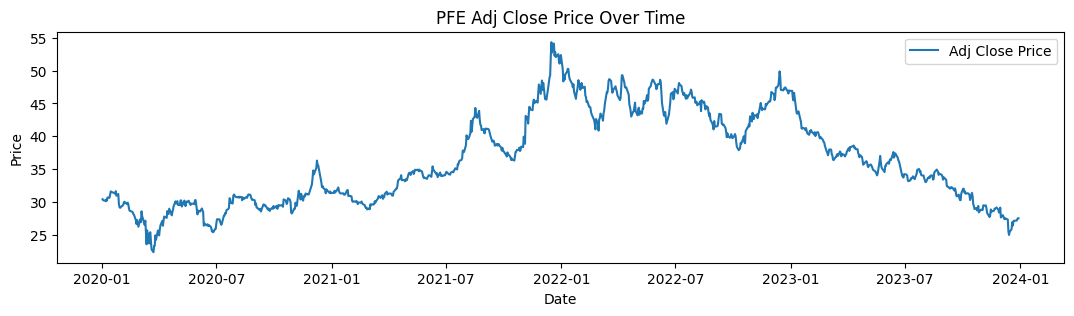

In [18]:
plt.figure(figsize=(13, 3))
plt.plot(df.index, df['Adj Close'], label='Adj Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('PFE Adj Close Price Over Time')
plt.legend()

plt.show()

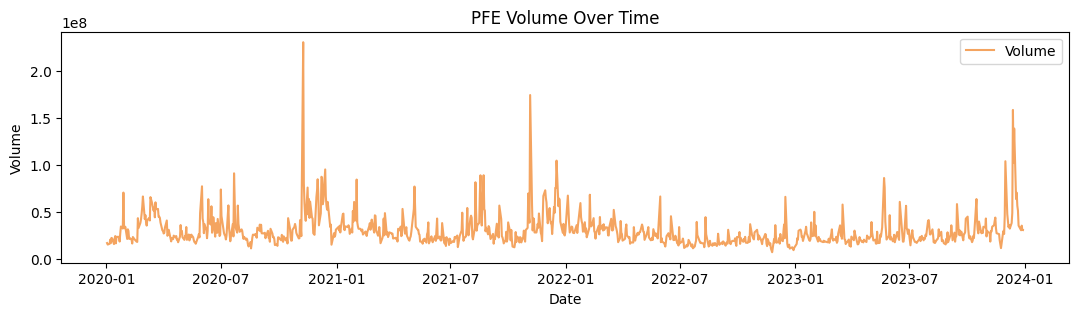

In [19]:
plt.figure(figsize=(13, 3))
plt.plot(df.index, df['Volume'], color = 'sandybrown', label='Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('PFE Volume Over Time')
plt.legend()

plt.show()

1.5 위 시각화 과정을 통해 알 수 있는 내용에 대해 작성하세요.

위 그래프에서 볼 수 있듯, 화이자의 수정 종가는 2022년까지는 상승세였지만 그 이후로는 계속 하락세를 보이고 있습니다.

# 2. 추세 및 정상성 검정

2.1 시계열 데이터의 정상성을 검증하도록 하겠습니다. 시계열 데이터 말하는 정상성(stationarity)이 무엇인지 왜 해야 하며 비정상성의 해결 방법에는 무엇이 있는지 작성하세요.

시계열 데이터가 말하는 정상성이란 시간에 상관없이 일정한 성질을 띠고 있는 것을 말합니다. 비정상성을 해결할려면 차분, 로그 변환, Box-cox 변환, 계절성 차분 등등이 있습니다.

2.2 먼저 ADF Test를 수행하겠습니다. statsmodels의 adfuller 라이브러리를 import 한 후 수정 종가에 대한 검정을 수행하고 결과를 출력하세요(p-value 포함).

ADF Test란? - https://hongl.tistory.com/98

In [20]:
result = adfuller(df['Adj Close'])

print(f'ADF statistics : {result[0]}')
print(f'p-value {result[1]}')
print('critical values: ')
for key, value in result[4].items():
    print(f"\t{key} {value}")

ADF statistics : -1.6730172183812775
p-value 0.4450656784025114
critical values: 
	1% -3.4369994990319355
	5% -2.8644757356011743
	10% -2.5683331327427803


2.3 ADF Test 결과를 해석하세요.

ADF test에서의 p-value는 귀무가설이 맞을 확률을 나타내며, 이 값이 0.05보다 작으면 귀무가설을 기각하고, 시계열 데이터가 안정적이라는 결론을 내릴 수 있습니다. 반대로, 이 값이 0.05보다 크면 귀무가설을 기각하지 못하고, 시계열 데이터가 안정적이 아니라 불안정(non-stationary) 하다고 판단합니다.

p-value가 0.44 이상이므로 staionary 합니.

2.4 ACF 그래프와 PACF 그래프를 그려보도록 하겠습니다. 먼저 ACF와 PACF 각각이 어떻게 다른지 설명하세요.

[자기상관함수(Autocorrelation Fucntion, ACF)]

먼저 ACF에 대해서 정리해보도록 하겠습니다. ACF는 yt와 yt+k
사이에 correlation을 측정하는 것입니다. PACF는 t와 t+k 사이의 다른 y값들의 영향력을 배제하고 측정하는 것입니다

2.5 statsmodels의 plot_acf, plot_pacf 라이브러리를 import하고 Adj close값에 대한 ACF, PACF 그래프를 출력하세요.

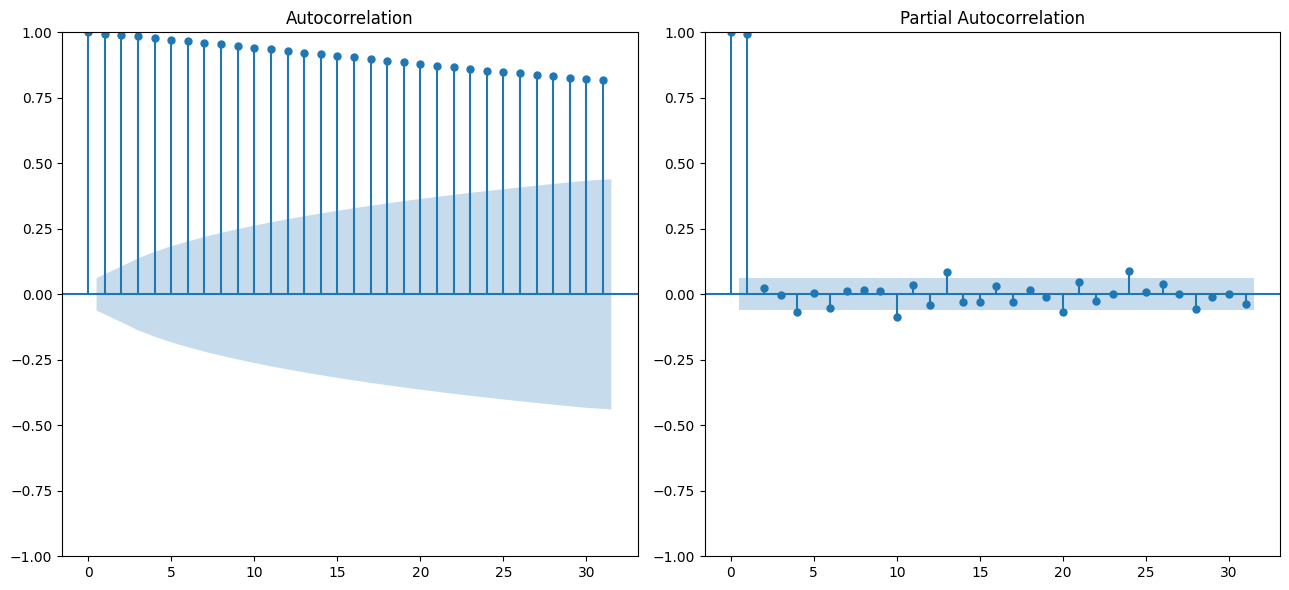

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6))

plot_acf(df['Adj Close'], ax=axes[0], title='Autocorrelation')
plot_pacf(df['Adj Close'], ax=axes[1], title='Partial Autocorrelation')

plt.tight_layout()
plt.show()

2.6 결과를 해석하세요.

왼쪽 그래프를 보시면 모든 값들이 1에 가까운 값을 가지는 것을 볼 수 있습니다. 또한 매우 천천히 correlation이 내려가고 있고, 신뢰구간에 들지 않아서 비정상성을 가지고 있음을 알 수 있습니다.

오른쪽은 PACF 그래프인데 첫 값을 제외한 다른 부분들이 다 0에 가까운 것을 볼 수 있습니다.

2.7 마지막으로 계절성이 있는지 여부를 확인하겠습니다. statsmodels의 seasonal_decompose 라이브러리를 import하고 plot을 출력하세요.

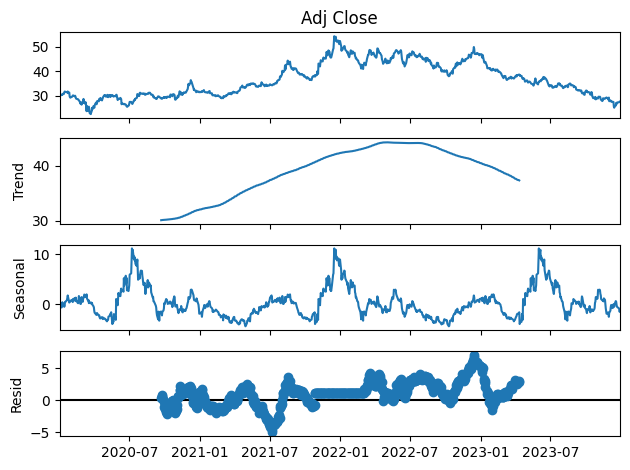

In [22]:
season = seasonal_decompose(df['Adj Close'], model='additive', period=365) #연간패턴을 보기 위해 period를 365로 설정
season.plot()

plt.show()

2.8 위 결과를 해석하세요.

Trend, 즉 장기적인 추세가 상승하다가 어느 시점부터 하락하는 것을 보여줍니다. 계절성 데이터는 주기적으로 변동하는 모습을 보이며 매년 반복하는 패턴을 띕니다.


2.9 위에서 진행한 검정 과정 및 시각화 결과를 종합해봤을 때 현 데이터는 비정상성임을 알 수 있습니다. 따라서 차분을 통해 이를 해결하도록 하겠습니다. 먼저 차분이 어떤 것인지에 대해 설명하세요.

차분이란 differencing으로 주어진 시계열의 변화분을 구하는 과정을 뜻합니다.

2.10 1차 차분을 진행하도록 하겠습니다. diff() 함수를 활용해 1차 차분을 진행한 후 ADF Test를 수행하여 정상성 여부를 확인하세요.

In [23]:
df['first_diff'] = df['Adj Close'].diff()

first_diff = df['first_diff'].dropna()

In [24]:
adf_diff = adfuller(first_diff)

print(f'ADF statistics : {adf_diff[0]}')
print(f'p-value {adf_diff[1]}')
print('critical values: ')
for key, value in adf_diff[4].items():
    print(f"\t{key} {value}")

ADF statistics : -6.82302513410752
p-value 1.979691476483785e-09
critical values: 
	1% -3.4370266558635914
	5% -2.864487711945291
	10% -2.5683395116993872


2.11 추가로 위에서 그려보았던 plot들을 다시 그려보면서 비교를 통해 정상성 여부를 확인해보도록 하겠습니다. ACF PACF plot, 계절성 분해 plot을 그려보세요.

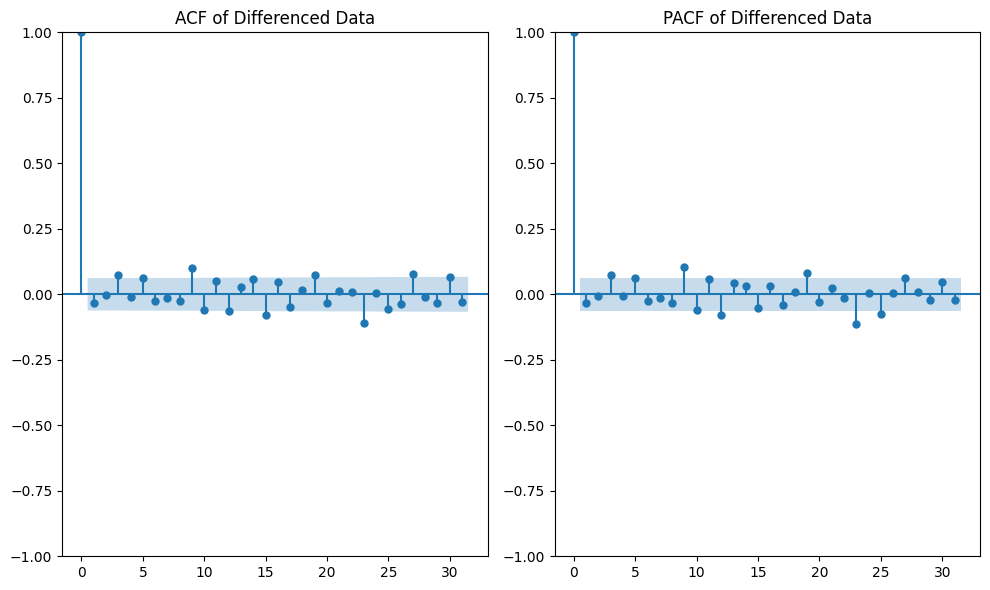

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

plot_acf(first_diff, ax=axes[0], title='ACF of Differenced Data')
plot_pacf(first_diff, ax=axes[1], title='PACF of Differenced Data')

plt.tight_layout()
plt.show()

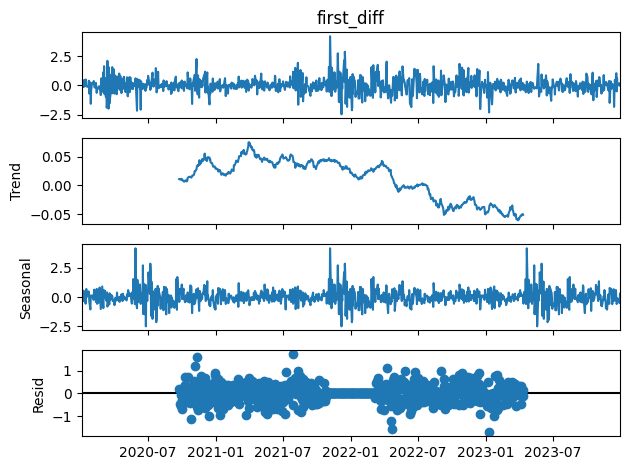

In [26]:
season_diff = seasonal_decompose(first_diff, model='additive', period=365)
season_diff.plot()

plt.show()

# 3. 예측

3.1 데이터의 정상성을 확인했으니 본격적으로 예측 및 분석을 진행해보도록 하겠습니다.


아래 코드는 예시이므로 예시에서 사용된 모델이 아닌 다른 모델(ex. ARIMAX, ARCH/GARCH, LSTM, Transformer, DLinear etc.)를 사용하고 애플이 아닌 다른 주식을 사용해 예측 및 분석을 진행해주세요(위에서 진행한 과정 역시 모두 예시이므로 새로운 주식에 대한 전처리 및 정상성 검정을 새로 진행해야 함).

In [27]:
df['Adj Close']

,Adj Close
Date,
2020-01-02,30.443781
2020-01-03,30.280445
2020-01-06,30.241554
2020-01-07,30.140429
2020-01-08,30.381559
...,...
2023-12-22,27.179701
2023-12-26,27.189272
2023-12-27,27.380680


In [28]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

In [29]:
data = df['Adj Close'].values
data = data.reshape(-1, 1)

In [30]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [31]:

def create_dataset(dataset, time_step=100):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 100
X, y = create_dataset(scaled_data, time_step)

In [32]:

X = X.reshape(X.shape[0], X.shape[1], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) #훈련, 테스트셋 분할

In [33]:
# LSTM 모델
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [34]:
model.compile(optimizer='adam', loss='mean_squared_error')

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - loss: 0.1380 - val_loss: 0.0052
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0134 - val_loss: 0.0076
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0072 - val_loss: 0.0041
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step

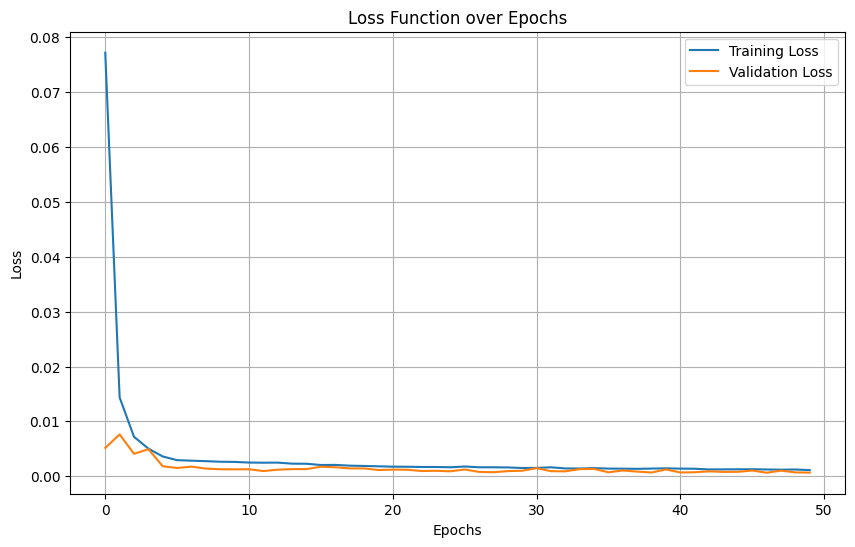

In [35]:
history = model.fit(X_train, y_train, batch_size=64, epochs=50, verbose=1, validation_data=(X_test, y_test))

# 훈련 손실, 검증 손실 저장
loss = history.history['loss']  # 훈련 손실
val_loss = history.history['val_loss']  # 검증 손실

# 에폭 수에 따른 손실 함수 감소 추이 시각화
plt.figure(figsize=(10,6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Function over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
y_pred = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


In [37]:
# 복원
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

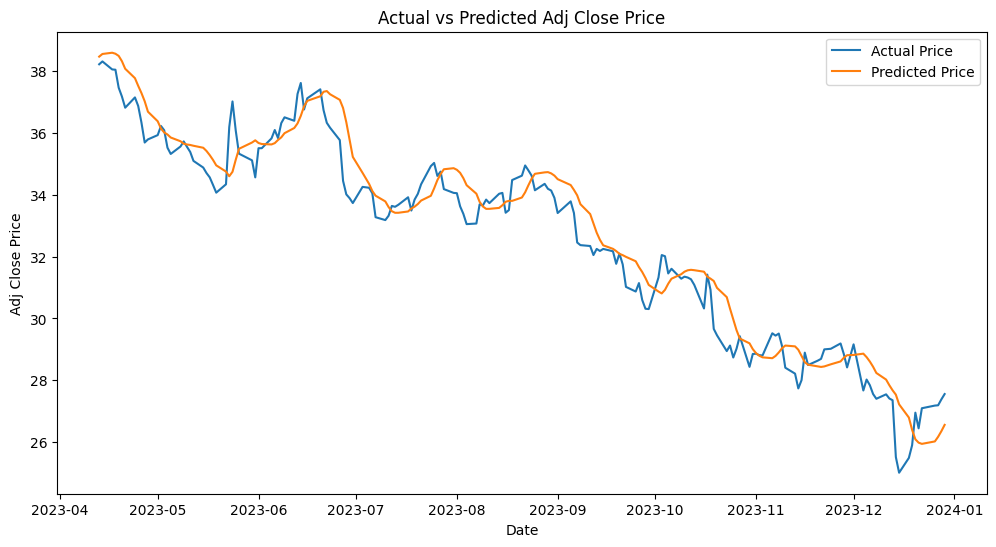

In [38]:
plt.figure(figsize=(12,6))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Price')
plt.plot(df.index[-len(y_pred):], y_pred, label='Predicted Price')
plt.title('Actual vs Predicted Adj Close Price')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.legend()
plt.show()

In [39]:
from sklearn.metrics import mean_squared_error

# RMSE 출력
mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

RMSE: 0.8164814295548183
